#Running AI Weather Prediction (AIWP) models

This notebook will guide you through the process of running AIWP models yourself using only free cloud resources provided through Google Colab. if you aren't interested in running the models yourself but would like to see output, use our other notebook.

**Points where user interaction is required are marked in bold**

Estimated Time: 70 minutes

Questions? Contact jacob.radford@noaa.gov

#1) AI Weather Prediction Background Information

##1.1) What is an AI Weather Prediction Model?

AIWP models are weather models that have been trained to identify relationships between the state of the atmosphere at time t=0 and the state of the atmosphere at time t+1 using historical data like ECMWF's Reanalysis v5 (ERA5). The model can then be combined with any initial atmospheric state to predict a future state. For example, the model can use the atmospheric state at 00 UTC on Jan 1, 2025 to make a weather prediction for 06 UTC on Jan 1, 2025. It then takes its prediction for 06 UTC on Jan 1, 2025 as the input to predict the state at 12 UTC on Jan 1, 2025, and so on until the desired forecast length is reached (usually 10 days). This iterative process is referred to as an autoregressive model.

##1.2) How do they differ from traditional weather models (AKA Numerical Weather Prediction)?

Numerical Weather Prediction models use partial differential equations that represent our physical understanding of the atmosphere - things like conservation of momentum, conservation of energy, etc. AIWP models don't need any of this information because, in a way, they can learn these sorts of relationships from the historical data. NWP models are very computationally expensive and take a long time to run, even on supercomputers. Meanwhile, you can run an AIWP model in minutes right here!

##1.3) What about forecast skill? How do AIWP models compare to NWP models?

State of the art AIWP models have been shown to have performance comparable to or better than NWP models in many regards. For example, in this chart from WeatherBench2, blue squares indicate variables where the AIWP model outperforms the IFS HRES NWP model (a state of the art NWP model) in terms of root mean squared error (RMSE). The Pangu-Weather and GraphCast squares are almost all blue!

![WeatherBench2](https://shorturl.at/AUtBV)

Results have been very exciting for the meteorological community. That said, there are some caveats - perhaps the the biggest one is that which model is "better" can be subjective. Just because one model has lower RMSE than another doesn't mean it's necessarily better for your use case. For example, a couple of commonly cited limitations for AIWP models is that they may struggle to predict extreme events like strong hurricanes or intense precipitation and that they tend to produce "blurry" looking output for longer range forecasts. Furthermore, one model may perform better than another in particular regions or for specific types of weather events. More research is being done to identify specific strengths and weaknesses of different models.

##1.4) If I can run competitive weather models myself, will that make NOAA obsolete?

Definitely not. There are many reasons that NOAA will have a vital role in the future of weather forecasting, AI-based or otherwise:

1.   AIWP models still fundamentally rely on NOAA's data assimilation processes. Data assimilation is the process through which weather observations across the globe are combined to create a "best-guess" at the current state of the atmosphere. The output of the data assimilation system is what is then used to initialize AIWP models.
2.   Most AIWP models are limited in spatial resolution to 0.25° (~30km) because they are trained on ERA5 data, which itself has a resolution of 0.25°. 0.25° models are unable to capture many smaller, impactful meteorological features like thunderstorms. Traditional NWP models like the High-Resolution Rapid Refresh have spatial resolution of 3km and are much more capable of resolving smaller scale features.
3.   AIWP models predict a limited subset of meteorological variables. For example, variables related to precipitation type, wind gusts, and cloud parameters are currently not predicted by any AIWP models.
4.   There are still lingering questions about how well AIWP models can represent extreme weather events like hurricanes, intense precipitation, cold snaps, heat waves, etc.
5.   NOAA is taking an active role in AIWP model research and exploring how to incorporate AIWP into operations to make weather forecasts more accurate.
6.   The human factor: more accurate models are only one part of the equation. How the output of these models is then communicated to the general public is where NOAA really shines.

#2) Getting Started with AIWP on Google Colab

In this section we give instructions on connecting to Google Colab cloud resources, configuring the environment, running an AIWP model, and converting the output from grib format to NetCDF4 format.

**Section 2 Estimated Time: 20 minutes**

##2.1) Connecting to a runtime

In the upper right corner of this page you will see "Connect" with a dropdown arrow next to it. This is how you will connect to the cloud compute resources needed to run AIWP models. Which type of runtime you need to connect to depends on which models you want to run and whether or not you have paid for Colab compute units.

Not all models can run on all runtime types. See the table below to check compatability and speed. Some models, like 0.25° GraphCast, can't be run on any of the Colab resources (at least in my trials)!

Color code:

*   Green - Model runs fast on runtime
*   Yellow - Model can technically run on runtime, but slowly
*   Red - Model cannot be run on runtime

![Benchmarks](https://i.imgur.com/uvRmq4L.png)

**For the purposes of this tutorial, we will use the free T4 GPU, which can run FourCastNetv2-small, Pangu-Weather, and GraphCast 1.00°.**

**Click the dropdown arrow, then "change runtime type," select T4 GPU and save. Finally, click "connect" to connect to the runtime.**

**T4 GPUs are typically, but not always, available.**

##2.2) Configuring the environment (what's under the hood?)

The next step for running AIWP models is installing packages built specifically for this purpose.

The core functionality comes from a package developed by ECMWF called [ai-models](https://github.com/ecmwf-lab/ai-models). ai-models does everything for you - retrieving the data, formatting the data to what is expected by each AIWP model, running the models, and writing the output to grib files.

ai-models is limited to ECMWF hosted data like ERA5 and IFS initial conditions, which require API keys and doesn't include NOAA data. To address this, I made a branch of ai-models called ai-models-gfs that can also retrieve GFS, GDAS, or GEFS initial conditions.

The other packages (like ai-models-graphcast-gfs) are just plug-ins for the ai-models package to allow it to run each model.

After that we import all of the packages needed for the whole notebook.

**Run this cell wihout modification.**

**At some point Colab may tell you that you need to restart the runtime. If it does, restart and then run this cell again.**


In [1]:
#Install all of the required packages
!pip install ai-models-gfs

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━

In [1]:
!pip install ai-models-graphcast-gfs
# !pip install ai-models-fourcastnetv2-gfs
# !pip install ai-models-panguweather-gfs
# !pip install ai-models-aurora-gfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.9/373.9 kB 32.1 MB/s eta 0:00:00


In [2]:
!pip install git+https://github.com/deepmind/graphcast.git

  Cloning https://github.com/deepmind/graphcast.git to /tmp/pip-req-build-qv711_bo
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/graphcast.git /tmp/pip-req-build-qv711_bo
  Resolved https://github.com/deepmind/graphcast.git to commit c0376564b94581c973cd085df7c515237b77cc6b
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 148.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.6/736.6 kB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 163.7 MB/s eta 0:00:00
  Created wheel for graphcast: filename=graphcast-0.2.0.dev0-py3-none-any.whl size=136

In [3]:
!pip install xarray pygrib awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 145.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 141.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 150.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9.1
    Uninstalling rsa-4.9.1:
      Successfully uninstalled rsa-4.9.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.


In [4]:
!pip install basemap basemap-data-hires

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 137.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ai-models-gfs 0.0.21 requires numpy<2, but you have numpy 2.3.5 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
opencv-py

In [1]:
#!pip install jax[tpu] // Uncomment if running models on a TPU runtime

#These are the imports needed for the rest of the notebook
import numpy as np
import xarray as xr
import pygrib as pg
import ipywidgets as widgets
import math
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.basemap import Basemap, shiftgrid
from IPython.display import HTML
from typing import Optional
from netCDF4 import Dataset as DS

##2.3) Downloading model assets

Before running the models we need to download them! This can technically be handled internally by ai-models or ai-models-gfs, but it's a bit faster to just download them before-hand from our S3 bucket with AWS command line interface.

**Run this cell without modification.**

In [2]:
!aws s3 cp --recursive --no-sign-request s3://noaa-oar-mlwp-data/colab_resources/fcnv2 ./fcnv2/
!aws s3 cp --recursive --no-sign-request s3://noaa-oar-mlwp-data/colab_resources/pw ./pw/
!aws s3 cp --recursive --no-sign-request s3://noaa-oar-mlwp-data/colab_resources/au ./au/
!aws s3 cp --recursive --no-sign-request s3://noaa-oar-mlwp-data/colab_resources/gc ./gc/

download: s3://noaa-oar-mlwp-data/colab_resources/fcnv2/global_means.npy to fcnv2/global_means.npy
download: s3://noaa-oar-mlwp-data/colab_resources/fcnv2/global_stds.npy to fcnv2/global_stds.npy
download: s3://noaa-oar-mlwp-data/colab_resources/fcnv2/weights.tar to fcnv2/weights.tar
download: s3://noaa-oar-mlwp-data/colab_resources/pw/pangu_weather_24.onnx to pw/pangu_weather_24.onnx
download: s3://noaa-oar-mlwp-data/colab_resources/pw/pangu_weather_6.onnx to pw/pangu_weather_6.onnx
download: s3://noaa-oar-mlwp-data/colab_resources/au/aurora-0.25-static.pickle to au/aurora-0.25-static.pickle
download: s3://noaa-oar-mlwp-data/colab_resources/au/aurora-0.25-finetuned.ckpt to au/aurora-0.25-finetuned.ckpt
download: s3://noaa-oar-mlwp-data/colab_resources/gc/stats/mean_by_level.nc to gc/stats/mean_by_level.nc
download: s3://noaa-oar-mlwp-data/colab_resources/gc/stats/stddev_by_level.nc to gc/stats/stddev_by_level.nc
download: s3://noaa-oar-mlwp-data/colab_resources/gc/stats/diffs_stddev_b

##2.4) Running our first model

Now we're all set to run our first AIWP model!

We'll start with FourCastNetv2-small because it's fast and chronologically came first out of the models available here.

The first time you run this the model weights will need to be downloaded which can take a little while, after which the model will run.

**Specify the date, time, and model. You can also change the output path and how far out (lead time) the model runs.**

**For the first time through the notebook, I recommend keeping the default date/time/model/initial condition configuration.**

In [3]:
# Define input parameters

# Any date after Jan 1, 2021 in YYYYmmdd format
date = "20251126"

# Initialization time - must be one of ["0000", "0600", "1200", "1800"]
time = "1200"

# Model choices:
# ["fourcastnetv2-small", "panguweather", "graphcast",
# "graphcast-1p00", "aurora-2.5-finetuned"]
model = "graphcast"

# Dataset to use for initial conditions:
# "gfs" or "gdas" are easiest
# An empty string defaults to ECMWF MARS (need an account and api key)
# "cds" uses ERA5 (need an account and api key)
input_data = "gfs"

# Path to save output
output_path = f"./{model}_{date}_{time}"
# How far out to run model in hours
forecast_lead = "240"


# ** Don't change anything beyond this point **


# Map model choice to assets path
model2assets = {
    "fourcastnetv2-small":"./fcnv2",
    "panguweather":"./pw",
    "aurora-2.5-finetuned":"./au",
    "graphcast":"./gc",
    "graphcast-1p00":"./gc"
}


assets = model2assets[model]

# Runs the ai-models-gfs command
!ai-models-gfs \
    --input {input_data} \
    --date {date} \
    --time {time} \
    --assets {assets} \
    --path {output_path} \
    --lead {forecast_lead} \
    {model}

2025-11-28 20:44:56,917 INFO NumExpr defaulting to 12 threads.
2025-11-28 20:45:00,875 INFO Writing results to ./graphcast_20251126_1200
2025-11-28 20:45:00,876 INFO Loading surface fields from GFS
2025-11-28 20:45:08,442 INFO Downloading https://noaa-gfs-bdp-pds.s3.amazonaws.com/gfs.20251126/06/atmos/gfs.t06z.pgrb2.0p25.f000
File already exists: /tmp/sample_sfc.grib, skipping download.
2025-11-28 20:45:48,266 INFO Downloading https://noaa-gfs-bdp-pds.s3.amazonaws.com/gfs.20251126/12/atmos/gfs.t12z.pgrb2.0p25.f000
2025-11-28 20:46:27,998 INFO Loading pressure fields from GFS
File already exists: /tmp/sample_pres.grib, skipping download.
2025-11-28 20:47:27,264 INFO Starting date is 2025-11-26 12:00:00
2025-11-28 20:47:27,265 INFO Writing input fields
2025-11-28 20:47:27,645 INFO Writing step 0: 0.4 second.
2025-11-28 20:47:27,646 INFO Starting date is 2025-11-26 12:00:00
2025-11-28 20:47:27,646 INFO Writing input fields
2025-11-28 20:47:29,559 INFO Writing step 0: 1 second.
2025-11-28 

In [13]:
!ls -lrt

total 24
drwxr-xr-x 1 root root 4096 Jul 15 13:41 sample_data
drwxr-xr-x 2 root root 4096 Nov 28 20:43 fcnv2
drwxr-xr-x 2 root root 4096 Nov 28 20:43 pw
drwxr-xr-x 2 root root 4096 Nov 28 20:44 au
drwxr-xr-x 4 root root 4096 Nov 28 20:44 gc
drwx------ 5 root root 4096 Nov 28 22:01 drive


##2.5) Convert to NetCDF file

That's it! We ran a 240 hr weather forecast in just minutes. If you run that again (while still connected to the same runtime) for a different date or time it will be even faster because you won't have to download the models weights again.

The next step of converting the output to a NetCDF isn't strictly necessary, but makes the data easier to analyze, in my opinion.

**Run this cell without modification.**

In [5]:
# ** Don't modify any of this **

# Define the main function to convert GRIB files to NetCDF
def grib2nc(model, path, lead, step, date, time, inputmodel):

    # Mapping of variable names and their descriptions/units
    varmap = {
        "u10": ['10 metre U wind component', 'm s-1'],
        "v10": ['10 metre V wind component', 'm s-1'],
        "t2": ['2 metre temperature', 'K'],
        "msl": ['Pressure reduced to MSL', 'Pa'],
        "u100": ['100 metre U wind component', 'm s-1'],
        "v100": ['100 metre V wind component', 'm s-1'],
        "sp": ['Surface pressure', 'Pa'],
        "tcwv": ['Precipitable water', 'kg m-2'],
        "apcp": ['6-hr accumulated precipitation', 'm'],
        "u": ['U component of wind', 'm s-1'],
        "v": ['V component of wind', 'm s-1'],
        "t": ['Temperature', 'K'],
        "z": ['Geopotential', 'm2 s-2'],
        "r": ['Relative humidity', '%'],
        "q": ['Specific humidity', 'kg kg-1'],
        "w": ['Vertical velocity', 'Pa s-1']
    }

    # Mapping from ECMWF to GFS names
    ec2gfsmap = {
        "u": "u",
        "v": "v",
        "w": "w",
        "z": "z",
        "q": "q",
        "r": "r",
        "t": "t",
        "10u": "u10",
        "10v": "v10",
        "100u": "u100",
        "100v": "v100",
        "2t": "t2",
        "msl": "msl",
        "sp": "sp",
        "tcwv": "tcwv",
        "tp": "apcp"
    }

    # Initialize lists to store variables and levels
    unique_pl_vars = []
    unique_sfc_vars = []
    levels = []

    # Open the GRIB file and extract grid shape and lat/lon coordinates
    with pg.open(path) as grib:
        y_shape, x_shape = grib[1].values.shape
        lats, lons = grib[1].latlons()
        lats = lats[:, 0]
        lons = lons[0, :]

        # Identify pressure level and surface variables
        for grb in grib:
            if grb.levelType == "pl":
                if grb.level not in levels:
                    levels.append(grb.level)
                if grb.shortName not in unique_pl_vars:
                    unique_pl_vars.append(grb.shortName)
            else:
                if grb.shortName not in unique_sfc_vars:
                    unique_sfc_vars.append(grb.shortName)
        levels.sort(reverse=True)
        levelmap = {level: c for c, level in enumerate(levels)}

        # Create NetCDF file and define dimensions
        f = DS(f"{path}.nc", 'w', format='NETCDF4')
        f.createDimension('time', lead // step + 1)
        f.createDimension('level', len(levels))
        f.createDimension('longitude', x_shape)
        f.createDimension('latitude', y_shape)

        # Generate time values based on initialization date and time
        initdt = datetime.datetime.strptime(f"{date}{time}", "%Y%m%d%H00")
        times = np.array([
            int((initdt + datetime.timedelta(hours=int(i))).timestamp())
            for i in np.arange(0, lead + step, step)
        ])

        # Create coordinate variables in NetCDF
        create_variable_nochunk(f, 'time', ('time',), times, {
            'long_name': 'Date and Time', 'units': 'seconds since 1970-1-1',
            'calendar': 'standard'
        })
        create_variable_nochunk(f, 'longitude', ('longitude',), lons, {
            'long_name': 'Longitude', 'units': 'degree'
        })
        create_variable_nochunk(f, 'latitude', ('latitude',), lats, {
            'long_name': 'Latitude', 'units': 'degree'
        })
        create_variable_nochunk(f, 'level', ('level',), np.array(levels), {
            'long_name': 'Isobaric surfaces', 'units': 'hPa'
        })

        # Define variables in NetCDF for both pressure level and surface variables
        for variable in unique_pl_vars + unique_sfc_vars:
            dims = ('time', 'level', 'latitude', 'longitude') if variable in unique_pl_vars else ('time', 'latitude', 'longitude')
            chunksizes = (1, 1, y_shape, x_shape) if 'level' in dims else (1, y_shape, x_shape)
            gfsequivalent = ec2gfsmap[variable]
            create_variable(
                f, gfsequivalent, dims, None, {
                    'long_name': varmap[gfsequivalent][0],
                    'units': varmap[gfsequivalent][1]
                },
                chunksizes
            )

        # Populate NetCDF variables with data from GRIB
        grib.seek(0)
        for grb in grib:
            shortName = grb.shortName
            timestep = int(grb.step / step)
            level = grb.level
            levelType = grb.levelType
            if (shortName == 'z' and levelType == 'sfc') or shortName not in ec2gfsmap.keys():
                continue
            gfsequivalent = ec2gfsmap[shortName]
            vals = grb.values

            if levelType == 'pl':
                levelind = levelmap[level]
                f.variables[gfsequivalent][timestep, levelind, :, :] = vals
            elif levelType == 'sfc':
                f.variables[gfsequivalent][timestep, :, :] = vals

        # Add global attributes to the NetCDF file
        f.Conventions = 'CF-1.8'
        f.version = '3_2025-02-20'
        f.model_name = model
        f.initialization_model = inputmodel
        f.initialization_time = initdt.strftime('%Y-%m-%dT%H:%M:%S')
        f.first_forecast_hour = "0"
        f.last_forecast_hour = f"{lead}"
        f.forecast_hour_step = f"6"
        f.creation_time = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%S')
        f.close()

# Functions to create variables in the NetCDF file
def create_variable(f, name, dimensions, data, attrs, chunksizes):
    dtype = 'i4' if name in ['time', 'level'] else 'f4'
    var = f.createVariable(name, dtype, dimensions, compression='zlib', complevel=2, chunksizes=chunksizes)
    if data is not None:
        var[:] = data
    for attr_name, attr_value in attrs.items():
        var.setncattr(attr_name, attr_value)

def create_variable_nochunk(f, name, dimensions, data, attrs):
    dtype = 'i4' if name in ['time', 'level'] else 'f4'
    var = f.createVariable(name, dtype, dimensions, compression='zlib', complevel=2)
    var[:] = data
    for attr_name, attr_value in attrs.items():
        var.setncattr(attr_name, attr_value)

#Call the function
grib2nc(model, output_path, int(forecast_lead), 6, date, time, input_data)
!rm {output_path}


In [7]:
!ls -lrt

total 5680852
drwxr-xr-x 1 root root       4096 Jul 15 13:41 sample_data
drwxr-xr-x 2 root root       4096 Nov 28 20:43 fcnv2
drwxr-xr-x 2 root root       4096 Nov 28 20:43 pw
drwxr-xr-x 2 root root       4096 Nov 28 20:44 au
drwxr-xr-x 4 root root       4096 Nov 28 20:44 gc
-rw-r--r-- 1 root root 5817166688 Nov 28 21:54 graphcast_20251126_1200.nc


In [8]:
!du -sh graphcast_20251126_1200.nc

5.5G	graphcast_20251126_1200.nc


In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
!mkdir /content/drive/MyDrive/graphcast_outputs

In [12]:
!mv graphcast_20251126_1200.nc /content/drive/MyDrive/.

In [14]:
!ls -lrt /content/drive/MyDrive/graphcast_20251126_1200.nc

-rw-------+ 1 root root 5817166688 Nov 28 21:54 /content/drive/MyDrive/graphcast_20251126_1200.nc


#3) Visualization

In this section we provide two ways to visualize the output. First we make an animation - it provides functionality like play, pause, next, and previous buttons. After that we'll provide code for more traditional visualization with matplotlib.

**Section 3 Estimated Time: 10 minutes**

##3.1) Define the variable information

This cell is just a large dictionary defining some appropriate bounds for each variable and other general information like name and units.

**Only change this dictionary if you want to update minimum and maximum contour levels for a variable**

In [6]:
# Don't modify this unless you want to update contour levels

# These levels looked okay to me, but could almost certainly
# benefit from some adjustments

variable_levels = {
    # Surface variables
    'msl': {'min': 97500, 'max': 102500, 'name': 'mean sea level pressure', 'units': 'Pa'},
    'u10': {'min': -25, 'max': 25, 'name': '10m U wind component', 'units': 'm/s'},
    'v10': {'min': -25, 'max': 25, 'name': '10m V wind component', 'units': 'm/s'},
    'u100': {'min': -30, 'max': 30, 'name': '100m U wind component', 'units': 'm/s'},
    'v100': {'min': -30, 'max': 30, 'name': '100m V wind component', 'units': 'm/s'},
    't2': {'min': 179, 'max': 321, 'name': '2m temperature', 'units': 'K'},
    'tcwv': {'min': 0, 'max': 70, 'name': 'total column water vapor', 'units': 'kg/m²'},
    'sp': {'min': 75000, 'max': 105000, 'name': 'surface pressure', 'units': 'Pa'},
    'tp': {'min': 0, 'max': 2, 'name': 'total precipitation', 'units': 'm'},

    # Geopotential height (z) variables
    'z50': {'min': 168000, 'max': 213000, 'name': 'geopotential at 50 hPa', 'units': 'm^2/s^2'},
    'z100': {'min': 133000, 'max': 166000, 'name': 'geopotential at 100 hPa', 'units': 'm^2/s^2'},
    'z150': {'min': 109000, 'max': 143000, 'name': 'geopotential at 150 hPa', 'units': 'm^2/s^2'},
    'z200': {'min': 92000, 'max': 124000, 'name': 'geopotential at 200 hPa', 'units': 'm^2/s^2'},
    'z250': {'min': 80000, 'max': 109000, 'name': 'geopotential at 250 hPa', 'units': 'm^2/s^2'},
    'z300': {'min': 69300, 'max': 96400, 'name': 'geopotential at 300 hPa', 'units': 'm^2/s^2'},
    'z400': {'min': 52600, 'max': 75700, 'name': 'geopotential at 400 hPa', 'units': 'm^2/s^2'},
    'z500': {'min': 39200, 'max': 58900, 'name': 'geopotential at 500 hPa', 'units': 'm^2/s^2'},
    'z600': {'min': 28400, 'max': 44600, 'name': 'geopotential at 600 hPa', 'units': 'm^2/s^2'},
    'z700': {'min': 19200, 'max': 32300, 'name': 'geopotential at 700 hPa', 'units': 'm^2/s^2'},
    'z850': {'min': 6640, 'max': 16400, 'name': 'geopotential at 850 hPa', 'units': 'm^2/s^2'},
    'z925': {'min': 1600, 'max': 9600, 'name': 'geopotential at 925 hPa', 'units': 'm^2/s^2'},
    'z1000': {'min': -4000, 'max': 4000, 'name': 'geopotential at 1000 hPa', 'units': 'm^2/s^2'},

    # Temperature (t) variables
    't50': {'min': 180, 'max': 240, 'name': 'temperature at 50 hPa', 'units': 'K'},
    't100': {'min': 187, 'max': 237, 'name': 'temperature at 100 hPa', 'units': 'K'},
    't150': {'min': 190, 'max': 240, 'name': 'temperature at 150 hPa', 'units': 'K'},
    't200': {'min': 193, 'max': 243, 'name': 'temperature at 200 hPa', 'units': 'K'},
    't250': {'min': 196, 'max': 243, 'name': 'temperature at 250 hPa', 'units': 'K'},
    't300': {'min': 196, 'max': 252, 'name': 'temperature at 300 hPa', 'units': 'K'},
    't400': {'min': 203, 'max': 266, 'name': 'temperature at 400 hPa', 'units': 'K'},
    't500': {'min': 209, 'max': 281, 'name': 'temperature at 500 hPa', 'units': 'K'},
    't600': {'min': 211, 'max': 293, 'name': 'temperature at 600 hPa', 'units': 'K'},
    't700': {'min': 202, 'max': 302, 'name': 'temperature at 700 hPa', 'units': 'K'},
    't850': {'min': 198, 'max': 313, 'name': 'temperature at 850 hPa', 'units': 'K'},
    't925': {'min': 201, 'max': 319, 'name': 'temperature at 925 hPa', 'units': 'K'},
    't1000': {'min': 204, 'max': 323, 'name': 'temperature at 1000 hPa', 'units': 'K'},

    # Wind (u and v) components
    'u50':{'min': -70, 'max': 70, 'name': 'U wind component at 50 hPa', 'units': 'm/s'},
    'u100':{'min': -70, 'max': 70, 'name': 'U wind component at 100 hPa', 'units': 'm/s'},
    'u150':{'min': -70, 'max': 70, 'name': 'U wind component at 150 hPa', 'units': 'm/s'},
    'u200':{'min': -70, 'max': 70, 'name': 'U wind component at 200 hPa', 'units': 'm/s'},
    'u250':{'min': -70, 'max': 70, 'name': 'U wind component at 250 hPa', 'units': 'm/s'},
    'u300':{'min': -70, 'max': 70, 'name': 'U wind component at 300 hPa', 'units': 'm/s'},
    'u400':{'min': -50, 'max': 50, 'name': 'U wind component at 400 hPa', 'units': 'm/s'},
    'u500':{'min': -50, 'max': 50, 'name': 'U wind component at 500 hPa', 'units': 'm/s'},
    'u600':{'min': -40, 'max': 40, 'name': 'U wind component at 600 hPa', 'units': 'm/s'},
    'u700':{'min': -40, 'max': 40, 'name': 'U wind component at 700 hPa', 'units': 'm/s'},
    'u850':{'min': -30, 'max': 30, 'name': 'U wind component at 850 hPa', 'units': 'm/s'},
    'u925':{'min': -30, 'max': 30, 'name': 'U wind component at 925 hPa', 'units': 'm/s'},
    'u1000':{'min': -30, 'max': 30, 'name': 'U wind component at 1000 hPa', 'units': 'm/s'},

    'v50':{'min': -70, 'max': 70, 'name': 'V wind component at 50 hPa', 'units': 'm/s'},
    'v100':{'min': -70, 'max': 70, 'name': 'V wind component at 100 hPa', 'units': 'm/s'},
    'v150':{'min': -70, 'max': 70, 'name': 'V wind component at 150 hPa', 'units': 'm/s'},
    'v200':{'min': -70, 'max': 70, 'name': 'V wind component at 200 hPa', 'units': 'm/s'},
    'v250':{'min': -70, 'max': 70, 'name': 'V wind component at 250 hPa', 'units': 'm/s'},
    'v300':{'min': -70, 'max': 70, 'name': 'V wind component at 300 hPa', 'units': 'm/s'},
    'v400':{'min': -50, 'max': 50, 'name': 'V wind component at 400 hPa', 'units': 'm/s'},
    'v500':{'min': -50, 'max': 50, 'name': 'V wind component at 500 hPa', 'units': 'm/s'},
    'v600':{'min': -40, 'max': 40, 'name': 'V wind component at 600 hPa', 'units': 'm/s'},
    'v700':{'min': -40, 'max': 40, 'name': 'V wind component at 700 hPa', 'units': 'm/s'},
    'v850':{'min': -30, 'max': 30, 'name': 'V wind component at 850 hPa', 'units': 'm/s'},
    'v925':{'min': -30, 'max': 30, 'name': 'V wind component at 925 hPa', 'units': 'm/s'},
    'v1000':{'min': -30, 'max': 30, 'name': 'V wind component at 1000 hPa', 'units': 'm/s'},

    #specific humidity (q)
    'q50':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 50 hPa', 'units': 'kg/kg'},
    'q100':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 100 hPa', 'units': 'kg/kg'},
    'q150':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 150 hPa', 'units': 'kg/kg'},
    'q200':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 200 hPa', 'units': 'kg/kg'},
    'q250':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 250 hPa', 'units': 'kg/kg'},
    'q300':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 300 hPa', 'units': 'kg/kg'},
    'q400':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 400 hPa', 'units': 'kg/kg'},
    'q500':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 500 hPa', 'units': 'kg/kg'},
    'q600':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 600 hPa', 'units': 'kg/kg'},
    'q700':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 700 hPa', 'units': 'kg/kg'},
    'q850':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 850 hPa', 'units': 'kg/kg'},
    'q925':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 925 hPa', 'units': 'kg/kg'},
    'q1000':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 1000 hPa', 'units': 'kg/kg'},

    # relative Humidity (r)
    **{f'r{level}': {'min': 0, 'max': 100, 'name': f'relative humidity at {level} hPa', 'units': '%'}
       for level in [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]},

    # Vertical Velocity (w)
    **{f'w{level}': {'min': -1, 'max': 1, 'name': f'vertical velocity at {level} hPa', 'units': 'm/s'}
       for level in [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]}
}

##3.2) Choose variable information and create animation

**You need to fill in some options:**

*   **Available variables by model:**

<img src="https://i.imgur.com/eAHYuPb.png" alt="Variables" width="600">

*   **level (if the variable is on pressure levels):**
1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50, or 0 for single level variables
*   **lat_bounds and lon_bounds if you want to subset to certain domains**
*   **plot_size if you want to make the plot bigger or smaller**
*   **colormap if you want something other than viridis**

In [ ]:
ds = xr.open_dataset(f"{output_path}.nc")
ds

<xarray.Dataset> Size: 16GB
Dimensions:    (time: 41, level: 13, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 328B 2025-10-07T12:00:00 ... 2025-10-17T...
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) int32 52B 1000 925 850 700 600 500 ... 250 200 150 100 50
Data variables:
    z          (time, level, latitude, longitude) float32 2GB ...
    r          (time, level, latitude, longitude) float32 2GB ...
    q          (time, level, latitude, longitude) float32 2GB ...
    t          (time, level, latitude, longitude) float32 2GB ...
    u          (time, level, latitude, longitude) float32 2GB ...
    v          (time, level, latitude, longitude) float32 2GB ...
    w          (time, level, latitude, longitude) float32 2GB ...
    u10        (time, latitude, longitude) float32 170MB ...
    v10        (time, latitude, longitude) float32 170MB ...
    t2         (time, latitude, longitude) float32 170MB ...
    msl        (time, latitude, longitude) float32 170MB ...
    apcp       (time, latitude, longitude) float32 170MB ...
Attributes:
    Conventions:           CF-1.8
    version:               3_2025-02-20
    model_name:            graphcast
    initialization_model:  gfs
    initialization_time:   2025-10-07T12:00:00
    first_forecast_hour:   0
    last_forecast_hour:    240
    forecast_hour_step:    6
    creation_time:         2025-10-07T22:52:07

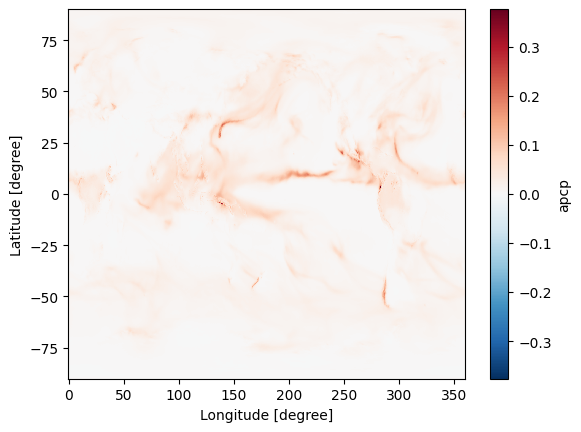

In [ ]:
ds.apcp.mean(dim='time').plot()